In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates,
    MAMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.trainer.multioutput import TrainerEnsemble

In [3]:
from enum import Enum
UncertaintyMethod = Enum('UncertaintyMethod', 'pred_var MI pred_entropy KL pred_entropy_single')
uncertaintyMethod = "pred_entropy"
# uncertaintyMethod = "pred_var"
# uncertaintyMethod = "MI"
# uncertaintyMethod = "KL"

# uncertaintyMethod = "pred_entropy_single"


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:

config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10,
	"removePolygons": True,
	"uncertainty_method": uncertaintyMethod
}
print(config)

'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''


# dates = [2020, 2021]
# dataset = MAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
site = 'PA'
if site == 'PA':
	dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif site == 'MT':
	dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = config['inference_times']


if config['training'] == False:

	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140
trainer = TrainerEnsemble(config, dataset, patchesHandler)

trainer.defineExperiment(exp_ids)


{'training': False, 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'inference_times': 10, 'removePolygons': True, 'uncertainty_method': 'pred_entropy'}


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]

In [7]:
# trainer.setExperimentPath()
# trainer.createLogFolders()

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


In [ ]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [ ]:

trainer.label_mask.dtype

dtype('uint8')

In [ ]:
unique, count = np.unique(trainer.label_mask, return_counts=True)
print(unique, count)

total = np.sum(count)
percentage_count = [round(x*100, 1) for x in count / total]
print(percentage_count)

[0 1 2] [100903598   1838508  60373894]
[61.9, 1.1, 37.0]


In [ ]:
# pdb.set_trace()

In [ ]:

trainer.getLabelCurrentDeforestation()

In [ ]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [ ]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

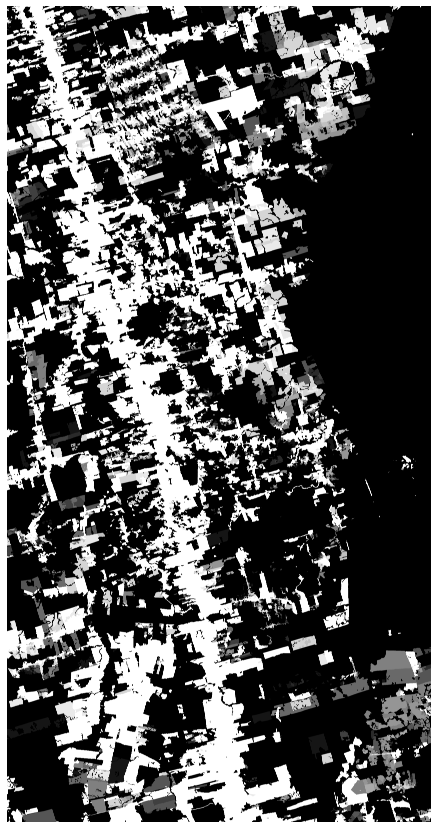

In [ ]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [ ]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [ ]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [ ]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [ ]:
if config["training"] == True:
    trainer.extractCoords()

In [ ]:
if config["training"] == True:
    trainer.trainTestSplit()

In [ ]:
if config["training"] == True:
    trainer.label_mask.shape

In [ ]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [ ]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [ ]:
if config["training"] == True:
    print(trainer.coords_train)

In [ ]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [ ]:
if config["training"] == True:
    inputSnipShow = True

In [ ]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [ ]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [ ]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [ ]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [ ]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [ ]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [ ]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [ ]:
if config["training"] == True:
    trainer.getGenerators()


In [ ]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [ ]:
if config["training"] == True:
    print(trainer.path_exp)

In [ ]:
if config["training"] == True:
    print(trainer.channels)

In [ ]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [ ]:
if config["training"] == True:
    trainer.train()

In [ ]:
if config["training"] == True:
    trainer.plotHistory()


In [ ]:
trainer.image_stack.shape

(17730, 9200, 21)

In [ ]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [ ]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]


In [ ]:
trainer.image_stack.shape

(17730, 9200, 21)

In [ ]:
trainer.setPadding()

-30.0 -16.0


In [ ]:
trainer.infer()

time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [ ]:
trainer.loadPredictedProbabilities()

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 3, 10)

In [ ]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 3, 10)

In [ ]:
trainer.getMeanProb()


In [ ]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 1.500655e-16
    np.mean(value): 0.014949512
    np.max(value): 0.9961816


In [ ]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [ ]:
trainer.unpadMeanProb()

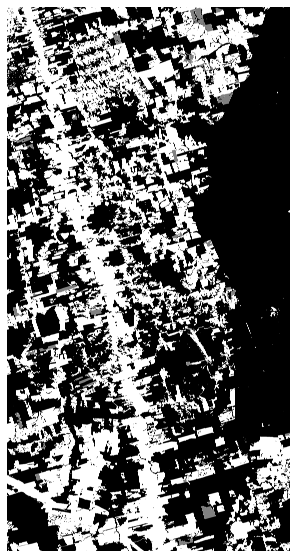

In [ ]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [ ]:
trainer.squeezeLabel()

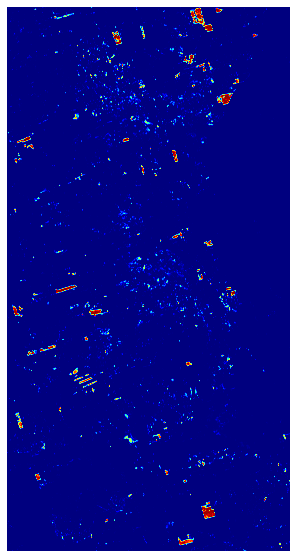

In [ ]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [ ]:
print(trainer.label_mask.shape)

(17730, 9200)


In [ ]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [ ]:
# trainer.getMAP()

In [ ]:
trainer.prob_rec.shape

(17760, 9216, 3, 10)

In [ ]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(10, 17760, 9216, 3)


In [ ]:
trainer.prob_rec.shape

(10, 17760, 9216, 3)

In [ ]:
trainer.logger.getStats(trainer.prob_rec)

ic| np.min(value): 0.0, np.mean(value): 0.33224776, np.max(value): 1.0


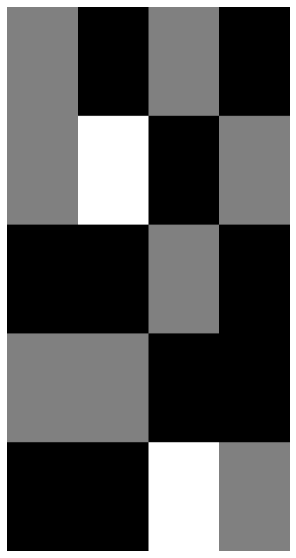

In [ ]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [ ]:
trainer.getLabelCurrentDeforestation()

In [ ]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161192339,   1923661], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [ ]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [ ]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161192339,   1923661], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161368428,   1747572], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162939911,    176089], dtype=int64))


In [ ]:
trainer.calculateMetrics()

ic| self.f1: 85.77, self.precision: 88.45, self.recall: 83.24


In [ ]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9431485,)
ic| f1_val: 87.05
    precision_val: 84.03
    recall_val: 90.3
    mAP_val: 92.71


In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [ ]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162560284,    555716], dtype=int64))


In [ ]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


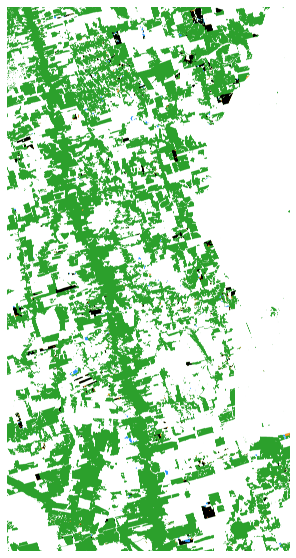

In [ ]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [ ]:
'''
import types

trainer.setUncertainty = types.MethodType(setUncertainty, trainer)
'''


'\nimport types\n\ntrainer.setUncertainty = types.MethodType(setUncertainty, trainer)\n'

In [ ]:
trainer.setUncertainty()

In [ ]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.036095694
    np.max(value): 0.99999857


ic| trainer.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

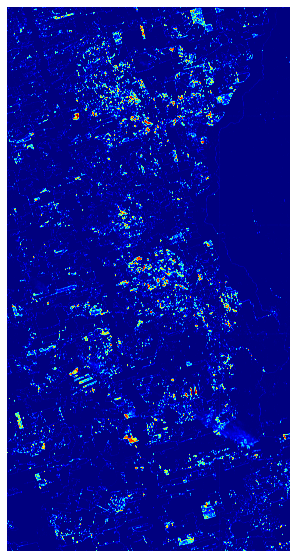

In [ ]:

trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(trainer.uncertainty_to_show.shape)



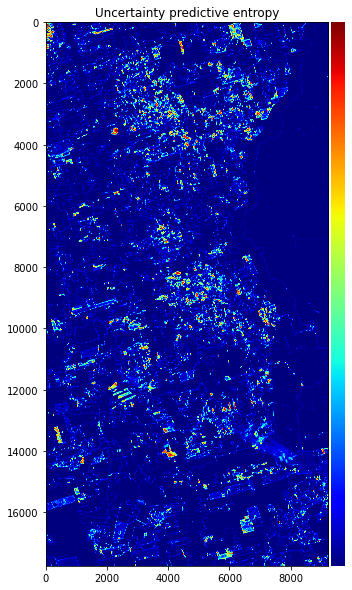

In [ ]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(trainer.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

In [ ]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54147114,)


ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


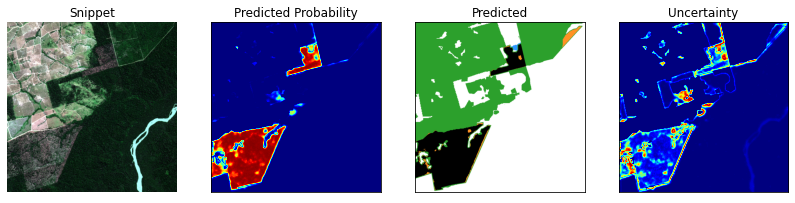

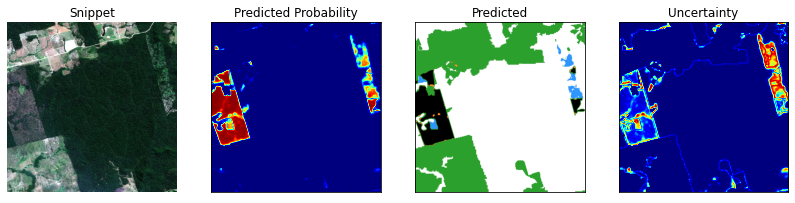

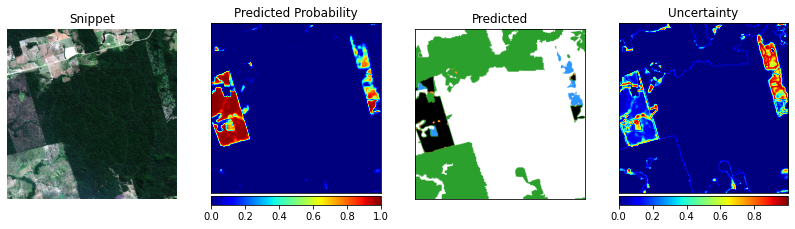

In [ ]:
trainer.logger.plotCropSample(trainer)

In [ ]:
del trainer.image_stack
from src.paths import PathsPara
from src.lansdatLoader import LandsatLoader

paths = PathsPara()
landsatLoader = LandsatLoader(dataset.site, paths)
ims = landsatLoader.load()
trainer.logger.plotCropSampleLandsat(trainer, landsatLoader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


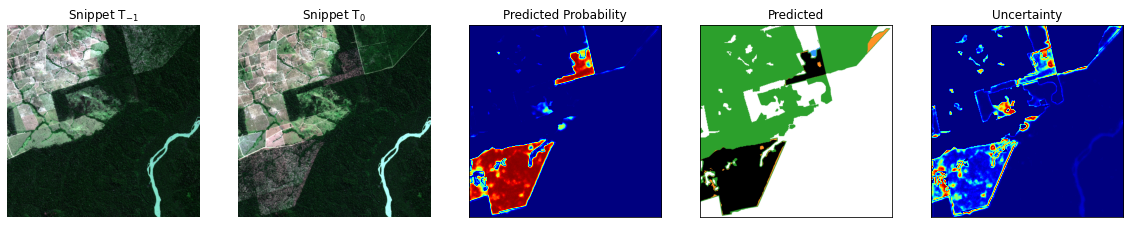

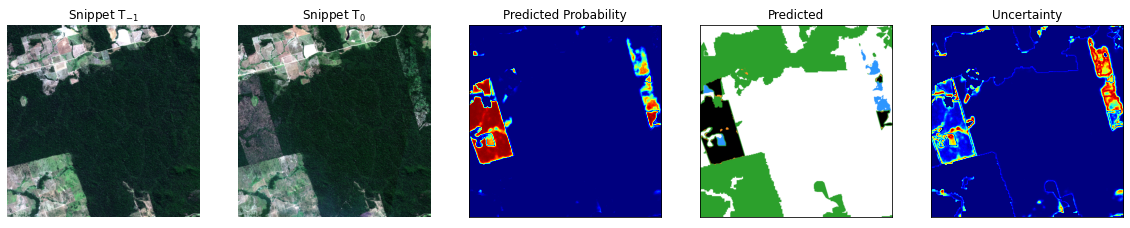

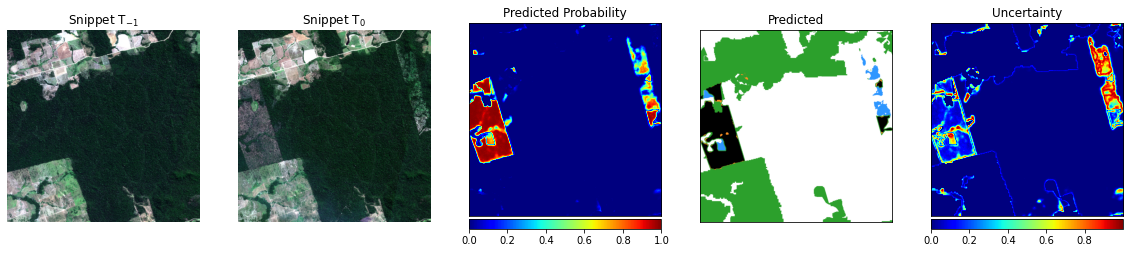

In [ ]:
trainer.logger.plotCropSampleT0T1(trainer)

In [ ]:
'''
dataset.previewLims1 = np.array([200, 700, 10200, 11200])
dataset.previewLims2 = np.array([2500, 3500, 6000, 7000])
'''

'\ndataset.previewLims1 = np.array([200, 700, 10200, 11200])\ndataset.previewLims2 = np.array([2500, 3500, 6000, 7000])\n'

In [ ]:
'''
import importlib
importlib.reload(_plt)
plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        importlib.reload(_plt)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims,
                colorbar = True)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertaintyColorbar_.png', dpi=150, bbox_inches='tight')
'''

"\nimport importlib\nimportlib.reload(_plt)\nplotCropSampleFlag = True\nif plotCropSampleFlag == True:\n        importlib.reload(_metrics)\n        importlib.reload(_plt)\n        # import matplotlib\n        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])\n        ic(dataset.previewLims1, dataset.previewLims2)\n        lims = dataset.previewLims1\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))\n        lims = dataset.previewLims2\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))\n\n        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, \n                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, \n                lims = dataset.previewLims1, \n                titles = ['Snippet $\\mathregular{T_{-1}}$', 'Snippet $\\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],\n                cmaps = [plt.cm.gray, plt.cm.gray

In [ ]:
trainer.logger.getStats(trainer.uncertainty)


ic| np.min(value): 0.00014246842
    np.mean(value): 0.04995148
    np.max(value): 0.99999857


In [ ]:
trainer.getOtherUncertaintyMetrics()
print(trainer.sUEO)

print(trainer.ece_score)  

(54147114,) (54147114,)
0.4141211131277548
0.046205365324648015
0.4141211131277548
0.046205365324648015


In [ ]:
trainer.uncertainty.shape

(54147114,)

In [ ]:
def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [ ]:

import types

trainer.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, trainer)



Get precision-recall threshold

In [ ]:

trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54147114,)
    self.label_mask_current_deforestation_test.shape: (54147114,)


[0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9969985694885254, 0.9984985694885254]
threshold 0.0025
(35112675,) (35112675,)


ic| label_current_deforestation_test_classified_incorrect.shape: (19034439,)
    predicted_test_classified_incorrect.shape: (19034439,)


cm_correct [[35111731        0]
 [     944        0]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:292: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_L = TP_L / (TP_L + FP_L)
ic| TP_H + FN_H + FP_H + TN_H: 19034439
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 19034439
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[18221333    79815]
 [  122085   611206]]
[       nan 0.         0.         0.35153192 0.884497   0.83351084
 0.01060656]
threshold 0.025
(44745782,) (44745782,)


ic| label_current_deforestation_test_classified_incorrect.shape: (9401332,)
    predicted_test_classified_incorrect.shape: (9401332,)


cm_correct [[44740845        0]
 [    4937        0]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:292: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_L = TP_L / (TP_L + FP_L)
ic| TP_H + FN_H + FP_H + TN_H: 9401332
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 9401332
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[8592219   79815]
 [ 118092  611206]]
[       nan 0.         0.         0.17362573 0.884497   0.83807442
 0.0210399 ]
threshold 0.05
(46624350,) (46624350,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7522764,)
    predicted_test_classified_incorrect.shape: (7522764,)


cm_correct [[46606641        0]
 [    6853    10856]]


ic| TP_H + FN_H + FP_H + TN_H: 7522764
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 7522764
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[6726423   79815]
 [ 116176  600350]]
[1.         0.61302163 0.01478546 0.13893195 0.88265347 0.83786213
 0.02602935]
threshold 0.1
(48534460,) (48534460,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5612654,)
    predicted_test_classified_incorrect.shape: (5612654,)


cm_correct [[48415397        0]
 [    8950   110113]]


ic| TP_H + FN_H + FP_H + TN_H: 5612654
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 5612654
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[4917667   79815]
 [ 114079  501093]]
[1.         0.92482971 0.1499697  0.10365564 0.86260303 0.81455755
 0.03449087]
threshold 0.2
(50043164,) (50043164,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4103950,)
    predicted_test_classified_incorrect.shape: (4103950,)


cm_correct [[49778795       79]
 [   12181   252109]]


ic| TP_H + FN_H + FP_H + TN_H: 4103950
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 4103950
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[3554269   79736]
 [ 110848  359097]]
[0.99968674 0.95391048 0.34336282 0.07579259 0.8182999  0.76412559
 0.04630084]
threshold 0.4
(51557329,) (51557329,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2589785,)
    predicted_test_classified_incorrect.shape: (2589785,)


cm_correct [[51133490     2990]
 [   18518   402331]]


ic| TP_H + FN_H + FP_H + TN_H: 2589785
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 2589785
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[2199574   76825]
 [ 104511  208875]]
[0.99262313 0.95599847 0.54795944 0.04782868 0.73109905 0.66651031
 0.06944299]
threshold 0.5
(52112800,) (52112800,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2034314,)
    predicted_test_classified_incorrect.shape: (2034314,)


cm_correct [[51633674     6371]
 [   21991   450764]]


ic| TP_H + FN_H + FP_H + TN_H: 2034314
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 2034314
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[1699390   73444]
 [ 101038  160442]]
[0.9860632  0.95348331 0.61392334 0.03757013 0.68598377 0.61359186
 0.08459011]
threshold 0.6
(52632738,) (52632738,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1514376,)
    predicted_test_classified_incorrect.shape: (1514376,)
ic| TP_H + FN_H + FP_H + TN_H: 1514376
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + 

cm_correct [[52101461    12776]
 [   26601   491900]]
cm_incorrect [[1231603   67039]
 [  96428  119306]]


FP_H + TN_H: 1514376
    len(label_mask_current_deforestation_test): 54147114


[0.97468475 0.94869634 0.66994899 0.02796781 0.64024256 0.55302363
 0.10520784]
threshold 0.7
(53117936,) (53117936,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1029178,)
    predicted_test_classified_incorrect.shape: (1029178,)
ic| TP_H + FN_H + FP_H + TN_H: 1029178
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1029178
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52532659    23673]
 [   32458   529146]]
cm_incorrect [[800405  56142]
 [ 90571  82060]]
[0.95717767 0.94220483 0.72067662 0.01900707 0.59376854 0.47534916
 0.13518086]
threshold 0.8
(53415180,) (53415180,)


ic| label_current_deforestation_test_classified_incorrect.shape: (731934,)
    predicted_test_classified_incorrect.shape: (731934,)
ic| TP_H + FN_H + FP_H + TN_H: 731934
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 731934
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52770364    40852]
 [   40489   563475]]
cm_incorrect [[562700  38963]
 [ 82540  47731]]
[0.93240084 0.93296124 0.76743141 0.01351751 0.55056867 0.36639774
 0.14939965]
threshold 0.9
(53730536,) (53730536,)


ic| label_current_deforestation_test_classified_incorrect.shape: (416578,)
    predicted_test_classified_incorrect.shape: (416578,)
ic| TP_H + FN_H + FP_H + TN_H: 416578
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 416578
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53005117    70852]
 [   55827   598740]]
cm_incorrect [[327947   8963]
 [ 67202  12466]]
[0.89418631 0.91471156 0.81546099 0.00769345 0.58173503 0.15647437
 0.14020068]
threshold 0.9969985694885254
(54145296,) (54145296,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1818,)
    predicted_test_classified_incorrect.shape: (1818,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 1818
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1818
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53331708    79815]
 [  122567   611206]]
cm_incorrect [[1356    0]
 [ 462    0]]
[8.84496998e-01 8.32963328e-01 8.32439205e-01 3.35751966e-05
            nan 0.00000000e+00 2.26248776e-03]
threshold 0.9984985694885254
(54146287,) (54146287,)


ic| label_current_deforestation_test_classified_incorrect.shape: (827,)
    predicted_test_classified_incorrect.shape: (827,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 827
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 827
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53332467    79815]
 [  122799   611206]]
cm_incorrect [[597   0]
 [230   0]]
[8.84496998e-01 8.32700050e-01 8.32439205e-01 1.52732055e-05
            nan 0.00000000e+00 1.13054891e-03]


In [ ]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54147114,)
    self.label_mask_current_deforestation_test.shape: (54147114,)


threshold 0.0025
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [     944   733291]]
[1.         0.99871431]
threshold 0.025
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    4937   729298]]
[1.         0.99327599]
threshold 0.05
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    6853   727382]]
[1.         0.99066648]
threshold 0.1
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    8950   725285]]
[1.         0.98781044]
threshold 0.2
(54147114,) (54147114,)
cm_audited [[53412800       79]
 [   12181   722054]]
[0.9998906  0.98340994]
threshold 0.4
(54147114,) (54147114,)
cm_audited [[53409889     2990]
 [   18518   715717]]
[0.99583975 0.97477919]
threshold 0.5
(54147114,) (54147114,)
cm_audited [[53406508     6371]
 [   21991   712244]]
[0.99113433 0.9700491 ]
threshold 0.6
(54147114,) (54147114,)
cm_audited [[53400103    12776]
 [   26601   707634]]
[0.98226565 0.96377045]
threshold 0.7
(54147114,) (54147114,)
cm_audited [[53389206    236

ic| metric_values_audited: array([[1.        , 0.99871431],
                                  [1.        , 0.99327599],
                                  [1.        , 0.99066648],
                                  [1.        , 0.98781044],
                                  [0.9998906 , 0.98340994],
                                  [0.99583975, 0.97477919],
                                  [0.99113433, 0.9700491 ],
                                  [0.98226565, 0.96377045],
                                  [0.96736784, 0.95579344],
                                  [0.94438863, 0.94485553],
                                  [0.90543736, 0.92396576],
                                  [0.88457417, 0.83306843],
                                  [0.88453543, 0.83275246]])


cm_audited [[53333064    79815]
 [  122799   611436]]
[0.88453543 0.83275246]


In [ ]:
trainer.setPlotLimsForUncertaintyAA()

In [ ]:
'''
import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
'''


'\nimport types\n\ntrainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)\n'

In [ ]:
trainer.xlim


[-0.1, 10.4]

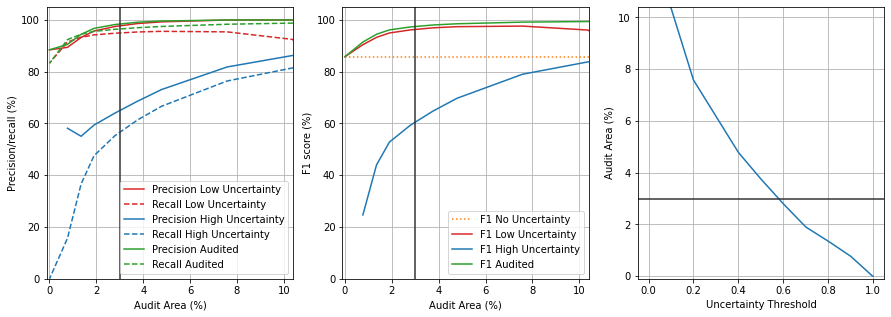

In [ ]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
trainer.plotUncertaintyAA()

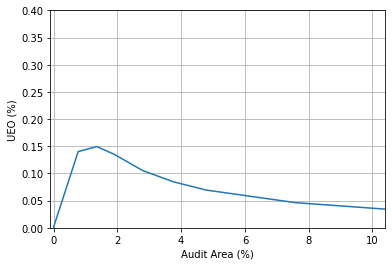

In [ ]:
trainer.plotUEO()

In [ ]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 0.9984985694885254)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38231956680959284
threshold 0.38231956680959284
(51450204,) (51450204,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2696910,)
    predicted_test_classified_incorrect.shape: (2696910,)


cm_correct [[51037122     2502]
 [   17977   392603]]


ic| TP_H + FN_H + FP_H + TN_H: 2696910
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 2696910
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[2295942   77313]
 [ 105052  218603]]
[0.99366751 0.9562156  0.53471028 0.04980709 0.73873329 0.67541981
 0.06711038]
0.6176790026789326
threshold 0.6176790026789326
(52740207,) (52740207,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1406907,)
    predicted_test_classified_incorrect.shape: (1406907,)
ic| TP_H + FN_H + FP_H + TN_H: 1406907
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H

cm_correct [[52199693    14229]
 [   27602   498683]]
cm_incorrect [[1133371   65586]
 [  95427  112523]]


 + FP_H + TN_H: 1406907
    len(label_mask_current_deforestation_test): 54147114


[0.9722584  0.94755313 0.67918718 0.02598305 0.63176482 0.54110604
 0.11114018]
0.7631391336191857
threshold 0.7631391336191857
(53309298,) (53309298,)


ic| label_current_deforestation_test_classified_incorrect.shape: (837816,)
    predicted_test_classified_incorrect.shape: (837816,)
ic| TP_H + FN_H + FP_H + TN_H: 837816
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 837816
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52687131    33779]
 [   37137   551251]]
cm_incorrect [[645933  46036]
 [ 85892  59955]]
[0.94226108 0.93688349 0.75078279 0.01547296 0.56566124 0.41108148
 0.14517812]
0.591675490751382
threshold 0.591675490751382
(52586445,) (52586445,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1560669,)
    predicted_test_classified_incorrect.shape: (1560669,)
ic| TP_H + FN_H + FP_H

cm_correct [[52059509    12140]
 [   26145   488651]]
cm_incorrect [[1273555   67675]
 [  96884  122555]]


 + TN_H: 1560669
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1560669
    len(label_mask_current_deforestation_test): 54147114


[0.97575835 0.94921289 0.66552398 0.02882275 0.64424644 0.55849234
 0.10291666]
0.5117086435517564
threshold 0.5117086435517564
(52172784,) (52172784,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1974330,)
    predicted_test_classified_incorrect.shape: (1974330,)


cm_correct [[51687590     6885]
 [   22444   455865]]


ic| TP_H + FN_H + FP_H + TN_H: 1974330
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1974330
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[1645474   72930]
 [ 100585  155341]]
[0.98512156 0.95307636 0.6208707  0.03646233 0.68051132 0.60697624
 0.08659907]
0.5716688292535473
threshold 0.5716688292535473
(52480249,) (52480249,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1666865,)
    predicted_test_classified_incorrect.shape: (1666865,)
ic

cm_correct [[51963629    10774]
 [   25124   480722]]
cm_incorrect [[1369435   69041]
 [  97905  130484]]


| TP_H + FN_H + FP_H + TN_H: 1666865
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1666865
    len(label_mask_current_deforestation_test): 54147114


[0.97807917 0.95033271 0.65472499 0.030784   0.65397319 0.57132349
 0.09804418]
0.5766226961310886
threshold 0.5766226961310886
(52505817,) (52505817,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1641297,)
    predicted_test_classified_incorrect.shape: (1641297,)
ic

cm_correct [[51986692    11067]
 [   25380   482678]]
cm_incorrect [[1346372   68748]
 [  97649  128528]]


| TP_H + FN_H + FP_H + TN_H: 1641297
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1641297
    len(label_mask_current_deforestation_test): 54147114


[0.9775856  0.95004507 0.65738898 0.03031181 0.65151362 0.56826291
 0.09917902]
0.5803854777800307
threshold 0.5803854777800307
(52525886,) (52525886,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1621228,)
    predicted_test_classified_incorrect.shape: (1621228,)
ic

cm_correct [[52004861    11318]
 [   25564   484143]]
cm_incorrect [[1328203   68497]
 [  97465  127063]]


| TP_H + FN_H + FP_H + TN_H: 1621228
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1621228
    len(label_mask_current_deforestation_test): 54147114


[0.97715663 0.9498457  0.65938426 0.02994117 0.64973921 0.5659116
 0.10009107]
0.5846978790016597
threshold 0.5846978790016597
(52548695,) (52548695,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1598419,)
    predicted_test_classified_incorrect.shape: (1598419,)
ic

cm_correct [[52025455    11619]
 [   25768   485853]]
cm_incorrect [[1307609   68196]
 [  97261  125353]]


| TP_H + FN_H + FP_H + TN_H: 1598419
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1598419
    len(label_mask_current_deforestation_test): 54147114


[0.97664391 0.94963459 0.66171321 0.02951993 0.64765512 0.56309576
 0.10114708]
0.5801501392436098
threshold 0.5801501392436098
(52524637,) (52524637,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1622477,)
    predicted_test_classified_incorrect.shape: (1622477,)
ic

cm_correct [[52003740    11298]
 [   25546   484053]]
cm_incorrect [[1329324   68517]
 [  97483  127153]]


| TP_H + FN_H + FP_H + TN_H: 1622477
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1622477
    len(label_mask_current_deforestation_test): 54147114


[0.97719193 0.94987039 0.65926168 0.02996424 0.6498339  0.56604017
 0.10004092]
0.5792216708321144
threshold 0.5792216708321144
(52519735,) (52519735,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1627379,)
    predicted_test_classified_incorrect.shape: (1627379,)
ic

cm_correct [[51999294    11245]
 [   25508   483688]]
cm_incorrect [[1333770   68570]
 [  97521  127518]]


| TP_H + FN_H + FP_H + TN_H: 1627379
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1627379
    len(label_mask_current_deforestation_test): 54147114


[0.97727975 0.94990534 0.65876456 0.03005477 0.65031006 0.56664845
 0.09980639]
0.5797954958678991
threshold 0.5797954958678991
(52522782,) (52522782,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624332,)
    predicted_test_classified_incorrect.shape: (1624332,)
ic

cm_correct [[52002049    11283]
 [   25533   483917]]
cm_incorrect [[1331015   68532]
 [  97496  127289]]


| TP_H + FN_H + FP_H + TN_H: 1624332
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1624332
    len(label_mask_current_deforestation_test): 54147114


[0.97721527 0.94988124 0.65907645 0.0299985  0.65002732 0.56626999
 0.09994775]
0.5797360746437212
threshold 0.5797360746437212
(52522474,) (52522474,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624640,)
    predicted_test_classified_incorrect.shape: (1624640,)
ic

cm_correct [[52001768    11281]
 [   25527   483898]]
cm_incorrect [[1331296   68534]
 [  97502  127308]]


| TP_H + FN_H + FP_H + TN_H: 1624640
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1624640
    len(label_mask_current_deforestation_test): 54147114


[0.97721834 0.94989056 0.65905058 0.03000418 0.65005464 0.56629154
 0.09993451]
0.5798316950113754
threshold 0.5798316950113754
(52522969,) (52522969,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624145,)
    predicted_test_classified_incorrect.shape: (1624145,)
ic

cm_correct [[52002213    11285]
 [   25533   483938]]
cm_incorrect [[1330851   68530]
 [  97496  127268]]


| TP_H + FN_H + FP_H + TN_H: 1624145
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1624145
    len(label_mask_current_deforestation_test): 54147114
ic| self.threshold_optimal: 0.5797954958678991


[0.97721229 0.94988331 0.65910505 0.02999504 0.64999642 0.56622947
 0.09995768]


In [ ]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.5797954958678991
(52522782,) (52522782,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624332,)
    predicted_test_classified_incorrect.shape: (1624332,)
ic

cm_correct [[52002049    11283]
 [   25533   483917]]
cm_incorrect [[1331015   68532]
 [  97496  127289]]


| TP_H + FN_H + FP_H + TN_H: 1624332
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1624332
    len(label_mask_current_deforestation_test): 54147114


[0.97721527 0.94988124 0.65907645 0.0299985  0.65002732 0.56626999
 0.09994775]
threshold 0.5797954958678991
(54147114,) (54147114,)


ic| self.m_optimal: {'AA': array([0.0299985]),
                     'UEO': array([0.09994775]),
                     'f1': 85.77,
                     'f1_H': array([0.60526478]),
                     'f1_L': array([0.9633544]),
                     'precision_H': array([0.65002732]),
                     'precision_L': array([0.97721527]),
                     'recall_H': array([0.56626999]),
                     'recall_L': array([0.94988124]),
                     'recall_Ltotal': array([0.65907645])}
ic| self.m_audited_optimal: {'f1': array([0.97468334]),
                             'precision': array([0.98432884]),
                             'recall': array([0.96522503])}


cm_audited [[53401596    11283]
 [   25533   708702]]
[0.98432884 0.96522503]


{'metrics': {'precision_L': array([0.97721527]),
  'recall_L': array([0.94988124]),
  'recall_Ltotal': array([0.65907645]),
  'AA': array([0.0299985]),
  'precision_H': array([0.65002732]),
  'recall_H': array([0.56626999]),
  'UEO': array([0.09994775]),
  'f1_L': array([0.9633544]),
  'f1_H': array([0.60526478]),
  'f1': 85.77},
 'metrics_audited': {'precision': array([0.98432884]),
  'recall': array([0.96522503]),
  'f1': array([0.97468334])},
 'exp': 103}